In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
# Predefine colors for each class to avoid unnecessary random generation
def get_colors(classes):
    np.random.seed(42)
    return np.random.randint(0, 255, size=(len(classes), 3), dtype="uint8")

In [4]:
def load_yolo_model(weights_path, cfg_path):
    if not os.path.exists(weights_path) or not os.path.exists(cfg_path):
        raise FileNotFoundError("Model weights or configuration files missing.")
    return cv2.dnn.readNet(weights_path, cfg_path)

In [5]:
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Error loading image: {image_path}")
    return img

In [6]:
def perform_detection(yolo, img):
    height, width = img.shape[:2]
    blob = cv2.dnn.blobFromImage(img, 1/255, (416, 416), (0, 0, 0), swapRB=True, crop=False)
    yolo.setInput(blob)
    return yolo.forward(yolo.getUnconnectedOutLayersNames()), height, width

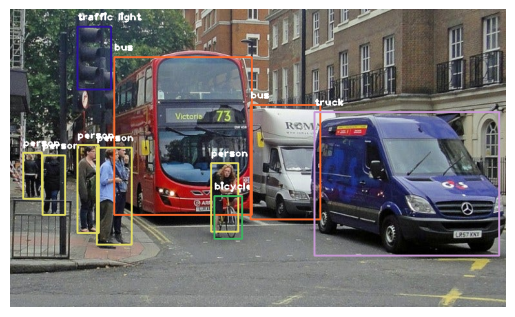

In [12]:
def get_colors(classes):
    np.random.seed(42)
    return np.random.randint(0, 255, size=(len(classes), 3), dtype="uint8")

def load_yolo_model(weights_path, cfg_path):
    if not os.path.exists(weights_path) or not os.path.exists(cfg_path):
        raise FileNotFoundError("Model weights or configuration files missing.")
    return cv2.dnn.readNet(weights_path, cfg_path)

def preprocess_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Error loading image: {image_path}")
    return img

def perform_detection(yolo, img):
    height, width = img.shape[:2]
    blob = cv2.dnn.blobFromImage(img, 1/255, (416, 416), (0, 0, 0), swapRB=True, crop=False)
    yolo.setInput(blob)
    return yolo.forward(yolo.getUnconnectedOutLayersNames()), height, width

def draw_detections(img, layer_output, height, width, classes, colors):
    boxes, confidences, class_ids = [], [], []

    for output in layer_output:
        for detection in output:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:  # Lowered confidence for more detections
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
    if len(indexes) > 0:
        indexes = indexes.flatten()
        for i in indexes:
            x, y, w, h = boxes[i]
            label = str(classes[class_ids[i]])
            color = colors[class_ids[i]]
            cv2.rectangle(img, (x, y), (x + w, y + h), color.tolist(), 2)
            cv2.putText(img, label, (x, y - 10), cv2.FONT_HERSHEY_PLAIN, 1, (255, 255, 255), 2)

def main(image_path="/content/drive/MyDrive/sample.jpg"):
    weights_path = "/content/drive/MyDrive/yolov3.weights"
    cfg_path = "/content/drive/MyDrive/yolov3.cfg"
    yolo = load_yolo_model(weights_path, cfg_path)

    with open(os.path.join("Dataset","/content/drive/MyDrive/coco.names"), 'r') as f:
        classes = f.read().splitlines()

    colors = get_colors(classes)

    img = preprocess_image(image_path)
    layer_output, height, width = perform_detection(yolo, img)

    draw_detections(img, layer_output, height, width, classes, colors)

    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

if __name__ == "__main__":
    main()